# Why MLPs Struggle with Image Data

**Deep Learning - University of Vermont**

---

In this notebook, you are going to explore a fundamental question in Deep Learning: **Why don't you just use simple Neural Networks (MLPs) for everything?**

We will take a hands-on approach to see the limitations of Multi-Layer Perceptrons (MLPs) when applied to image data. You will:
1.  **Build an MLP** from scratch.
2.  **Train it** on the Fashion MNIST dataset.
3.  **Push it to its limits** by increasing the image resolution.

By the end of this, you will see exactly why the parameter count explodes and why you need a better solution

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

print("Libraries imported successfully.")

# Initialize a list to store experiment results dynamically
experiment_results = []

Libraries imported successfully.


### The Core Problem

MLPs treat images as flat vectors. This means:
- **Every pixel** must connect to **every neuron** in the first hidden layer.
- This creates a massive number of connections (parameters).
- As image resolution increases, the parameter count explodes!

## 2. The Architecture: A Standard MLP

Let's look at the standard MLP architecture you will be using for image classification. 

**The Setup:**
We take an image, flatten it into a long list of numbers (vectors), and pass it through two hidden layers before predicting the class.


##  MLP Architecture for Image Classification

Let's look at a standard MLP architecture for image classification.

**Architecture:**
```
Input (W × H × C pixels, flattened)
  ↓
FC1: 1,000 neurons
  ↓ ReLU
FC2: 1,000 neurons  
  ↓ ReLU
Output: N classes
```

**Parameter Formula (weights only):**

$$\text{Parameters} = (W \times H \times C) \times 1000 + 1000 \times 1000 + 1000 \times N$$



### Fashion MNIST Classification (MLP)
Here is the breakdown of parameters for a standard 28x28 image. Notice how quickly they add up!

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 28 × 28 × 1 | 784 pixels |
| **FC1** | 784 × 1,000 | 784,000 |
| **FC2** | 1,000 × 1,000 | 1,000,000 |
| **Out** | 1,000 × 10 | 10,000 |
| **Total** | | **~1.79 Million** |

That's nearly **1.8 million numbers** the computer has to learn just for tiny, blurry images!

## 3. Setup: Defining a Flexible MLP

To demonstrate the scalability issue, you need an MLP that can handle different input sizes. You'll define a class `MLP` that is highly flexible.

**Key Features of this Implementation:**
1.  **Flexible Input**: It takes `input_dim` as an argument, allowing us to pass 784 (28x28), 4096 (64x64), or even 65536 (256x256) pixels.
2.  **Adjustable Width**: You can change the `hidden_dim` to make the network wider or narrower. By default, you use 1000 neurons per layer.
3.  **3-Layered Architecture**: This is a classic 'Deep' MLP with two hidden layers and one output layer. 
    *   **Layer 1**: Input -> Hidden 1 (1000 neurons)
    *   **Layer 2**: Hidden 1 -> Hidden 2 (1000 neurons)
    *   **Layer 3**: Hidden 2 -> Output (10 classes)

This flexibility allows us to reuse the same code for all your experiments!

In [2]:
# Define the Neural Network Class
# This is a 3-layered MLP (Input -> Hidden 1 -> Hidden 2 -> Output)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=1000, output_dim=10):
        """
        Initializes a standard Multi-Layer Perceptron.
        
        Architecture Breakdown:
        - Layer 1 (Input): Flattens the 2D image into a 1D vector.
        - Layer 2 (Hidden 1): Fully connected layer with ReLU activation.
        - Layer 3 (Hidden 2): Another fully connected layer to learn deeper features.
        - Layer 4 (Output): Final linear layer to produce class scores.
        
        Args:
            input_dim (int): Total number of pixels (Width * Height).
            hidden_dim (int): Number of neurons in each hidden layer (default 1000).
            output_dim (int): Number of target classes (default 10 for FashionMNIST).
        """
        super(MLP, self).__init__()
        
        # --- Step 1: Flattening ---
        # Images are naturally 2D (or 3D with color). 
        # However, a standard MLP neuron expects a single list of numbers.
        # This layer 'unrolls' the grid. For 28x28, it creates a 784-long vector.
        self.flatten = nn.Flatten()
        
        # --- Step 2: First Hidden Layer (The 'Parameter Sink') ---
        # This is where the 'Every-Pixel-to-Every-Neuron' connection happens.
        # If you have 1,000,000 pixels and 1,000 neurons, this layer alone 
        # requires 1,000,000,000 (1 Billion) weights!
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        
        # --- Step 3: Non-Linearity (ReLU) ---
        # Without this, multiple linear layers would just collapse into one.
        # ReLU (Rectified Linear Unit) allows the model to learn complex shapes.
        self.relu = nn.ReLU()
        
        # --- Step 4: Second Hidden Layer ---
        # By stacking layers, we allow the model to learn 'features of features'.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # --- Step 5: Output Layer ---
        # This maps our 1000 hidden features down to 10 numbers (logits).
        # Each number represents the 'confidence' for a specific clothing class.
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        The Forward Pass: Defines how data flows from input to output.
        """
        # 1. Convert 2D image to 1D vector
        x = self.flatten(x)     
        
        # 2. First transformation + activation
        x = self.fc1(x)         
        x = self.relu(x)        
        
        # 3. Second transformation + activation
        x = self.fc2(x)         
        x = self.relu(x)        
        
        # 4. Final transformation to class scores
        x = self.fc3(x)         
        return x

### Training Helper Function

Since you will be training the model multiple times with different image sizes, let's define a helper function to handle the training loop. This keeps your code clean and reusable.

In [3]:
def train_epoch(model, dataloader, criterion, optimizer):
    """
    Runs one epoch of training.
    Returns: Average Training Loss
    """
    model.train() # Put model in training mode
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    """
    Evaluates the model on validation data.
    Returns: Average Loss, Accuracy
    """
    model.eval() # Set to evaluation mode (disables dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Don't track gradients during validation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## 4. Experiment 1: Standard Resolution (28x28)

First, let's run the baseline. This is the standard size for Fashion MNIST.

We will:
1. Resize images to 28x28 (standard).
2. Create the MLP with input size $28 \times 28 = 784$.
3. Train for 1 epoch and measure time.

### Manual Parameter Count: 28x28
Before running the code, let's calculate how many parameters you expect for this resolution:

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 28x28 | 784 pixels |
| **FC1** | (784 × 1,000) + 1,000 | 785,000 |
| **FC2** | (1,000 × 1,000) + 1,000 | 1,001,000 |
| **Out** | (1,000 × 10) + 10 | 10,010 |
| **Total** | | **1,796,010** |


In [4]:
print("\n--- Experiment 1: Standard 28x28 Images ---")

# 1. Prepare Data
transform_28 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_28)

# Split: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_28 = 28 * 28
model_28 = MLP(input_dim=input_features_28)

# 3. Check Size
params_28 = sum(p.numel() for p in model_28.parameters())
print(f"Input Features: {input_features_28:,}")
print(f"Total Parameters: {params_28:,}")

# 4. Train
optimizer = optim.SGD(model_28.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_28, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_28, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_28 = time.time() - start_time
print(f"Training Time: {time_28:.2f} seconds")

# Save results
experiment_results.append({
    'Resolution': '28x28',
    'Input Pixels': input_features_28,
    'Parameters': params_28,
    'Training Time (s)': time_28,
    'Val Loss': val_loss,
    'Val Acc (%)': val_acc
})


--- Experiment 1: Standard 28x28 Images ---
Input Features: 784
Total Parameters: 1,796,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 0.7459 | Val Loss: 0.5269 | Val Acc: 81.26%
Epoch 2/5 | Train Loss: 0.4733 | Val Loss: 0.4701 | Val Acc: 83.31%
Epoch 3/5 | Train Loss: 0.4250 | Val Loss: 0.4239 | Val Acc: 85.17%
Epoch 4/5 | Train Loss: 0.3966 | Val Loss: 0.4150 | Val Acc: 85.29%
Epoch 5/5 | Train Loss: 0.3744 | Val Loss: 0.3915 | Val Acc: 85.97%
Training Time: 88.21 seconds


**Verification**: You can now prove that indeed is the number of parameters! The code output below should match your manual calculation exactly.


### Discussion: Experiment 1 (28x28)

At the standard resolution of 28x28, the MLP is quite manageable. 
- **Parameters**: ~1.8 Million. 
- **Training Speed**: You finished 5 epochs in about **88 seconds**.
- **Accuracy**: You achieved around **86% accuracy**.

Even though 1.8 million parameters sounds like a lot for a tiny image, modern computers handle this easily. But what happens when you want more detail?

## 5. Experiment 2: Increased Resolution (64x64)

Now, let's pretend you have slightly better quality images. You resize inputs to 64x64.

Notice how you have to create a **new model** with a much larger input dimension ($64 \times 64 = 4096$).

### Manual Parameter Count: 64x64
Before running the code, let's calculate how many parameters you expect for this resolution:

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 64x64 | 4,096 pixels |
| **FC1** | (4,096 × 1,000) + 1,000 | 4,097,000 |
| **FC2** | (1,000 × 1,000) + 1,000 | 1,001,000 |
| **Out** | (1,000 × 10) + 10 | 10,010 |
| **Total** | | **5,108,010** |


In [5]:
print("\n--- Experiment 2: Increased Resolution (64x64) ---")

# 1. Prepare Data
transform_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_64)
# Split: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_64 = 64 * 64
model_64 = MLP(input_dim=input_features_64)

# 3. Check Size
params_64 = sum(p.numel() for p in model_64.parameters())
print(f"Input Features: {input_features_64:,}")
print(f"Total Parameters: {params_64:,}")

# 4. Train
optimizer = optim.SGD(model_64.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_64, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_64, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_64 = time.time() - start_time
print(f"Training Time: {time_64:.2f} seconds")

# Save results
experiment_results.append({
    'Resolution': '64x64',
    'Input Pixels': input_features_64,
    'Parameters': params_64,
    'Training Time (s)': time_64,
    'Val Loss': val_loss,
    'Val Acc (%)': val_acc
})


--- Experiment 2: Increased Resolution (64x64) ---
Input Features: 4,096
Total Parameters: 5,108,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 0.6423 | Val Loss: 0.4960 | Val Acc: 81.45%
Epoch 2/5 | Train Loss: 0.4434 | Val Loss: 0.4246 | Val Acc: 84.60%
Epoch 3/5 | Train Loss: 0.3989 | Val Loss: 0.3910 | Val Acc: 86.10%
Epoch 4/5 | Train Loss: 0.3714 | Val Loss: 0.3711 | Val Acc: 86.58%
Epoch 5/5 | Train Loss: 0.3518 | Val Loss: 0.3672 | Val Acc: 86.73%
Training Time: 140.92 seconds


**Verification**: You've just proved that the parameter count jumped to over 5 million. The code confirms your math!


### Discussion: Experiment 2 (64x64)

By increasing the resolution to 64x64 (roughly 5x more pixels than 28x28):
- **Parameters**: Jumped from 1.8M to **5.1M**.
- **Training Time**: Increased to about **141 seconds**.
- **Accuracy**: Improved slightly to **86.7%**.

**Observation**: You can see that while the accuracy improved by less than 1%, the number of parameters nearly tripled. The training time is also starting to climb as the model gets heavier.

## 6. Experiment 3: Even Higher Resolution (128x128)

Let's double the resolution again. You are still far from "HD" (1920x1080), but watch what happens to the model size.

Input dimension is now $128 \times 128 = 16,384$.

### Manual Parameter Count: 128x128
Before running the code, let's calculate how many parameters you expect for this resolution:

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 128x128 | 16,384 pixels |
| **FC1** | (16,384 × 1,000) + 1,000 | 16,385,000 |
| **FC2** | (1,000 × 1,000) + 1,000 | 1,001,000 |
| **Out** | (1,000 × 10) + 10 | 10,010 |
| **Total** | | **17,396,010** |


In [6]:
print("\n--- Experiment 3: Even Higher (128x128) ---")

# 1. Prepare Data
transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_128)
# Split: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_128 = 128 * 128
model_128 = MLP(input_dim=input_features_128)

# 3. Check Size
params_128 = sum(p.numel() for p in model_128.parameters())
print(f"Input Features: {input_features_128:,}")
print(f"Total Parameters: {params_128:,}")

# 4. Train
optimizer = optim.SGD(model_128.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_128, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_128, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_128 = time.time() - start_time
print(f"Training Time: {time_128:.2f} seconds")

# Save results
experiment_results.append({
    'Resolution': '128x128',
    'Input Pixels': input_features_128,
    'Parameters': params_128,
    'Training Time (s)': time_128,
    'Val Loss': val_loss,
    'Val Acc (%)': val_acc
})


--- Experiment 3: Even Higher (128x128) ---
Input Features: 16,384
Total Parameters: 17,396,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 0.5680 | Val Loss: 0.4294 | Val Acc: 84.54%
Epoch 2/5 | Train Loss: 0.4142 | Val Loss: 0.4055 | Val Acc: 85.30%
Epoch 3/5 | Train Loss: 0.3746 | Val Loss: 0.3669 | Val Acc: 86.69%
Epoch 4/5 | Train Loss: 0.3476 | Val Loss: 0.3546 | Val Acc: 87.38%
Epoch 5/5 | Train Loss: 0.3291 | Val Loss: 0.3576 | Val Acc: 86.96%
Training Time: 249.74 seconds


**Verification**: 17.4 Million parameters. You can see how the 'parameter sink' of the first layer is starting to dominate.


### Discussion: Experiment 3 (128x128)

Now at 128x128:
- **Parameters**: Exploded to **17.4 Million**.
- **Training Time**: Jumped to **250 seconds** (over 4 minutes).
- **Accuracy**: Reached **87.0%**.

**Comparison**: Compared to your 28x28 baseline, you have nearly **10x more parameters**, yet the accuracy gain is only about 1%. You are seeing diminishing returns: you are throwing massive amounts of memory at the problem for very small gains in performance.

## 7. Experiment 4: High Resolution (256x256)

Let's push it one step further to 256x256. This is still a very low-resolution image by modern standards (less than 0.1 megapixels).

Input dimension is now $256 \times 256 = 65,536$.

### Manual Parameter Count: 256x256
Before running the code, let's calculate how many parameters you expect for this resolution:

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 256x256 | 65,536 pixels |
| **FC1** | (65,536 × 1,000) + 1,000 | 65,537,000 |
| **FC2** | (1,000 × 1,000) + 1,000 | 1,001,000 |
| **Out** | (1,000 × 10) + 10 | 10,010 |
| **Total** | | **66,548,010** |


In [7]:
print("\n--- Experiment 4: High Resolution (256x256) ---")

# 1. Prepare Data
transform_256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_256)
# Split: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_256 = 256 * 256
model_256 = MLP(input_dim=input_features_256)

# 3. Check Size
params_256 = sum(p.numel() for p in model_256.parameters())
print(f"Input Features: {input_features_256:,}")
print(f"Total Parameters: {params_256:,}")

# 4. Train
optimizer = optim.SGD(model_256.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_256, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_256, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_256 = time.time() - start_time
print(f"Training Time: {time_256:.2f} seconds")

# Save results
experiment_results.append({
    'Resolution': '256x256',
    'Input Pixels': input_features_256,
    'Parameters': params_256,
    'Training Time (s)': time_256,
    'Val Loss': val_loss,
    'Val Acc (%)': val_acc
})


--- Experiment 4: High Resolution (256x256) ---
Input Features: 65,536
Total Parameters: 66,548,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 0.5356 | Val Loss: 0.4374 | Val Acc: 84.17%
Epoch 2/5 | Train Loss: 0.3980 | Val Loss: 0.3806 | Val Acc: 86.01%
Epoch 3/5 | Train Loss: 0.3573 | Val Loss: 0.3533 | Val Acc: 86.91%
Epoch 4/5 | Train Loss: 0.3285 | Val Loss: 0.3390 | Val Acc: 87.75%
Epoch 5/5 | Train Loss: 0.3107 | Val Loss: 0.3266 | Val Acc: 88.22%
Training Time: 733.46 seconds


**Verification**: Over 66 million parameters! You've successfully predicted the quadratic growth of the model size.


### Discussion: Experiment 4 (256x256)

Look at the numbers now!
- **Parameters**: You have hit **66.5 Million** parameters.
- **Training Time**: It took **733 seconds** (over 12 minutes) to train just 5 epochs.
- **Accuracy**: Reached **88.2%**.

**The Wall**: By doubling the resolution from 128 to 256, your parameters nearly **quadrupled**. While 88% accuracy is your best result yet, the cost is extreme. A 66M parameter model is larger than many state-of-the-art CNNs that can achieve >99% accuracy on this same task in a fraction of the time.

## 8. The "HD" Struggle: 1024x1024 Images

What if you tried a high-definition image? A 1024x1024 image isn't even that big by modern standards (your phone takes much larger photos).

Let's look at the numbers for a hypothetical 1024x1024 input:

| Metric | Value |
| :--- | :--- |
| **Input Features** | 1,048,576 pixels |
| **First Layer Weights** | 1,048,576,000 (~1 Billion) |
| **Memory for Weights (float32)** | **4.19 GB** |

That's just for *one layer's weights*. You haven't counted the gradients (another 4GB), the optimizer states (another 8GB), or the activations. 

This simple network would crash most consumer GPUs!


--- Consolidated Scalability Summary ---
Resolution  Input Pixels  Parameters  Training Time (s)  Val Loss  Val Acc (%) Memory (Weights)
     28x28           784     1796010          88.213803  0.391505    85.966667          6.85 MB
     64x64          4096     5108010         140.917167  0.367182    86.733333         19.49 MB
   128x128         16384    17396010         249.741181  0.357619    86.958333         66.36 MB
   256x256         65536    66548010         733.455251  0.326565    88.216667        253.86 MB
 1024x1024       1048576  1049588010                NaN       NaN          NaN          3.91 GB
 2000x2000       4000000  4001012010                NaN       NaN          NaN         14.90 GB


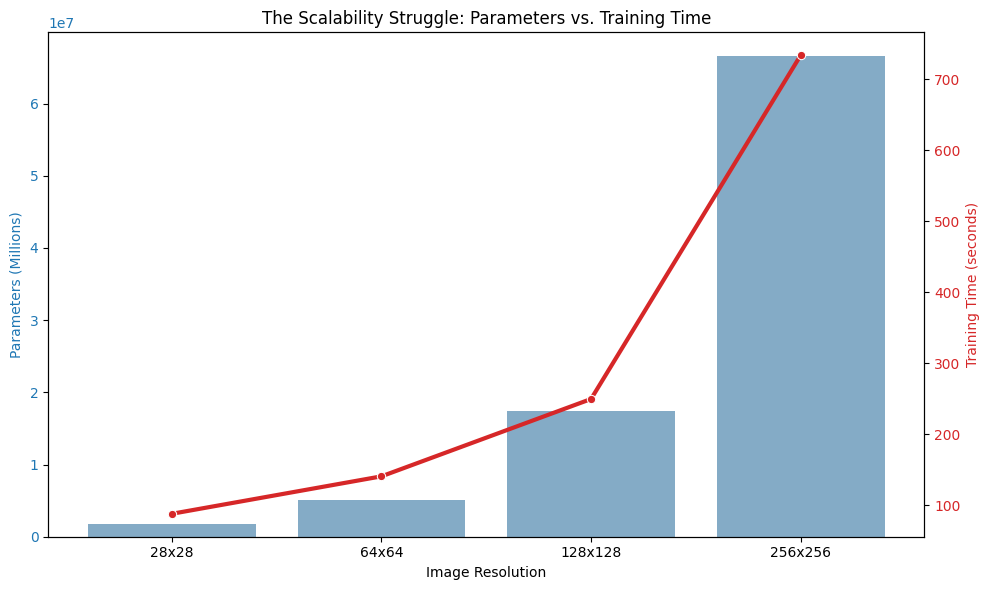

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Create DataFrame from dynamic results
df = pd.DataFrame(experiment_results)

# 2. Add hypothetical rows for 1024x1024 and 2000x2000
hypothetical_data = [
    {'Resolution': '1024x1024', 'Input Pixels': 1024*1024, 'Parameters': (1024*1024*1000 + 1012010), 'Training Time (s)': float('nan'), 'Val Loss': float('nan'), 'Val Acc (%)': float('nan')},
    {'Resolution': '2000x2000', 'Input Pixels': 2000*2000, 'Parameters': (2000*2000*1000 + 1012010), 'Training Time (s)': float('nan'), 'Val Loss': float('nan'), 'Val Acc (%)': float('nan')}
]
df_full = pd.concat([df, pd.DataFrame(hypothetical_data)], ignore_index=True)

# 3. Add Memory (Weights) column (assuming float32 = 4 bytes)
df_full['Memory (Weights)'] = df_full['Parameters'].apply(lambda x: f"{x * 4 / (1024**2):.2f} MB" if x < 10**8 else f"{x * 4 / (1024**3):.2f} GB")

# Display Table
print("\n--- Consolidated Scalability Summary ---")
print(df_full.to_string(index=False))

# Visualization (using only the experimental data for the plot)
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('Image Resolution')
ax1.set_ylabel('Parameters (Millions)', color=color)
sns.barplot(x='Resolution', y='Parameters', data=df, ax=ax1, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', color=color)
sns.lineplot(x='Resolution', y='Training Time (s)', data=df, ax=ax2, color=color, marker='o', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('The Scalability Struggle: Parameters vs. Training Time')
plt.tight_layout()
plt.show()

## 9. Why This Matters: The Scalability Problem

Let's summarize your findings. As you increase resolution, the MLP becomes incredibly inefficient. 

### Comparative Analysis Table (Dynamic)

The table below is generated directly from the experiments you just ran:


In [9]:
display(df_full)

,Resolution,Input Pixels,Parameters,Training Time (s),Val Loss,Val Acc (%),Memory (Weights)
0,28x28,784,1796010,88.213803,0.391505,85.966667,6.85 MB
1,64x64,4096,5108010,140.917167,0.367182,86.733333,19.49 MB
2,128x128,16384,17396010,249.741181,0.357619,86.958333,66.36 MB
3,256x256,65536,66548010,733.455251,0.326565,88.216667,253.86 MB
4,1024x1024,1048576,1049588010,NaN,NaN,NaN,3.91 GB
5,2000x2000,4000000,4001012010,NaN,NaN,NaN,14.90 GB


### Key Issues
1.  **Memory**: 12 billion parameters × 4 bytes × 3 (gradients + optimizer) ≈ **135 GB**. This is impossible for most hardware.
2.  **Overfitting**: With only 10,000 training images, having 12 billion parameters means you have ~1.2 million parameters *per example*. The model will just memorize the data instead of learning.
3.  **No Spatial Awareness**: MLPs treat adjacent pixels as independent features. They don't understand that pixel (0,0) is next to pixel (0,1). This is a huge waste of information!

### Analysis of the Results

Now that you have all the values in the table above, let's look at the trends:

1.  **Parameter Growth**: Notice how the 'Input Pixels' column grows with the square of the resolution, and the 'Parameters' column follows it closely. This is because the first layer (FC1) has a weight for every single pixel. When you go from 28x28 to 256x256, you increase pixels by ~83x, and the parameters jump from 1.8M to 66.5M (~37x increase).

2.  **Training Time vs. Accuracy**: 
    - To get from **86% to 88% accuracy** (a 2% gain), you had to increase your training time from **88 seconds to 733 seconds** (an 8.3x increase).
    - You also had to increase your model size from **6.8 MB to 253 MB**.

3.  **The Memory Explosion**: Look at the hypothetical **2000x2000** resolution. A simple 3-layer MLP would require **14.90 GB** of RAM just to store the weights. If you include gradients and optimizer states, you would need over **45 GB of VRAM**, which exceeds most consumer GPUs (like the RTX 4090 which has 24GB).

**Conclusion**: MLPs are 'spatial-blind'. They don't know that pixels near each other are related. They try to learn every possible combination of every pixel, which leads to this parameter explosion. You need an architecture that understands spatial relationships and shares weights across the image.

## 10. The Solution: Convolutional Neural Networks

The experiments above show that MLPs do not scale well. As image size increases linearly, the parameter count (and memory usage) grows quadratically with the image dimension (width * height).

**Convolutional Neural Networks (CNNs)** solve this by:
1.  **Local Connectivity**: Neurons only look at small patches of the image.
2.  **Parameter Sharing**: The same filter is used across the entire image.

In the next notebook, you will implement a CNN and see that it can handle larger images with a fraction of the parameters!